<a href="https://colab.research.google.com/github/hampen2929/esrgan_colab/blob/master/esrgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

ESRGANの超解像を試してみよう。

In [1]:
# 初期化
%cd '/content/'
!rm -rf '/content/esrgan/'

/content


# 作業ディレクトリの作成

In [2]:
!mkdir '/content/esrgan/'
%cd '/content/esrgan/'

/content/esrgan


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# データのダウンロードと解凍

## import

In [4]:
import os
import os.path as osp

## パスの定義

In [5]:
ROOT = '/content/esrgan/'

# Colabのローカルを使用する場合
DRIVE_ROOT = '/content/esrgan/'

# Google driveを使用する場合
# DRIVE_ROOT = '/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter4'

# 入力となるデータセットを保存するディレクトリ
input_dir = osp.join(ROOT, 'input')
os.makedirs(input_dir, exist_ok=True)

## ダウンロード

In [6]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P ./input/
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -P ./input/

--2021-02-07 03:25:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘./input/images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  65.8MB/s    in 11s     

2021-02-07 03:25:47 (66.8 MB/s) - ‘./input/images.tar.gz’ saved [791918971/791918971]

--2021-02-07 03:25:47--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘./input/annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  60.2MB/s    in 0.3s    

202

## 解凍

In [ ]:
!tar -zxvf ./input/images.tar.gz -C ./input/
!tar -zxvf ./input/annotations.tar.gz -C ./input/

# 超解像に用いる画像のラベル作成

## import 

In [8]:
from glob import glob
import shutil
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

## パスの定義

In [9]:
# 画像を保存するディレクトリ
image_dir = osp.join(input_dir, 'images')
# アノテーションデータを保存するディレクトリ
annotations_dir = osp.join(input_dir, 'annotations')
# アノテーションのリストファイルのパス
list_path = osp.join(annotations_dir, 'list.txt')

## ラベル作成のための定数

In [10]:
# データセットのラベル名
cols = ['file_name', 'class_id', 'species', 'breed_id']

## ラベルの読み込み

In [11]:
labels = []
with open(list_path, 'r') as f:
    lines = f.read().splitlines()
    for line in lines:
        if line.startswith('#'):
            continue
        labels.append(line.split(' '))
f.close()
labels_df = pd.DataFrame(labels, columns=cols)
labels_df = labels_df[['file_name', 'species']]

## データセットのラベル

In [12]:
labels_df

,file_name,species
0,Abyssinian_100,1
1,Abyssinian_101,1
2,Abyssinian_102,1
3,Abyssinian_103,1
4,Abyssinian_104,1
...,...,...
7344,yorkshire_terrier_96,2
7345,yorkshire_terrier_97,2
7346,yorkshire_terrier_98,2
7347,yorkshire_terrier_99,2


## ラベルを猫に絞る

In [13]:
cat_label_df = labels_df[labels_df.species=='1']
cat_label_df = cat_label_df.reset_index(drop=True)

## 作成した猫のデータセットのラベル

In [14]:
cat_label_df

,file_name,species
0,Abyssinian_100,1
1,Abyssinian_101,1
2,Abyssinian_102,1
3,Abyssinian_103,1
4,Abyssinian_104,1
...,...,...
2366,Sphynx_95,1
2367,Sphynx_96,1
2368,Sphynx_98,1
2369,Sphynx_99,1


# 画像の分割

## パスの定義

In [15]:
# データセットのディレクトリ
dataset_dir = osp.join(input_dir, 'cat_face')
# データセットの学習データを保存するディレクトリ
train_dir = osp.join(dataset_dir, 'train')
# データセットのテストデータを保存するディレクトリ
test_dir = osp.join(dataset_dir, 'test')
# デモ用のデータを保存するディレクトリ
demo_dir = osp.join(dataset_dir, 'demo')

## ランダムに切り出す際の定数

In [16]:
seed = 19930124
random_crop_times = 4
# クロップする画像のサイズ
crop_size = (128, 128) # (height, width)
dataset_name = 'cat_face'

## ランダムに切り出す関数の定義

In [17]:
def random_crop(image, crop_size):
    """画像を指定されたサイズになるようにランダムにクロップを行う

    Args:
        image (np.array): ランダムクロップする画像
        crop_size (tuple): ランダムクロップするサイズ

    Returns:
        np.array: ランダムクロップされた画像
    """
    
    h, w, _ = image.shape

    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])

    bottom = top + crop_size[0]
    right = left + crop_size[1]

    image = image[top:bottom, left:right, :]
    return image

## シード固定

In [18]:
np.random.seed(seed)

## 画像の分割

In [19]:
train_df, test_df = train_test_split(cat_label_df, test_size=5, random_state=seed)
train_df, demo_df = train_test_split(train_df, test_size=1, random_state=seed)

In [20]:
# 学習に用いる画像
for item in tqdm(train_df.file_name, total=len(train_df)):
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    # 画像のサイズがクロップする画像のサイズより小さいときは処理対象外とする
    if (h < crop_size[0]) | (w < crop_size[1]):
        print('{} size is invalid. h: {},  w: {}'.format(image_name, h, w))
        continue
    for num in range(random_crop_times):
        cropped_image = random_crop(image, crop_size=crop_size)
        image_save_name = '{}_{:03}.jpg'.format(item, num)
        cropped_image_save_path = osp.join(train_dir, image_save_name)
        os.makedirs(osp.dirname(cropped_image_save_path), exist_ok=True)
        cv2.imwrite(cropped_image_save_path, cropped_image)

 44%|████▍     | 1046/2365 [00:05<00:07, 176.58it/s]

Egyptian_Mau_122.jpg size is invalid. h: 112,  w: 150


 64%|██████▎   | 1506/2365 [00:08<00:04, 178.18it/s]

Bombay_171.jpg size is invalid. h: 108,  w: 144


 77%|███████▋  | 1821/2365 [00:10<00:02, 187.06it/s]

Abyssinian_63.jpg size is invalid. h: 116,  w: 150


 84%|████████▍ | 1997/2365 [00:11<00:01, 184.01it/s]

Bombay_103.jpg size is invalid. h: 143,  w: 114


 90%|████████▉ | 2127/2365 [00:12<00:01, 175.70it/s]

Egyptian_Mau_44.jpg size is invalid. h: 125,  w: 250


 92%|█████████▏| 2183/2365 [00:12<00:01, 174.31it/s]

Bombay_70.jpg size is invalid. h: 103,  w: 137


100%|██████████| 2365/2365 [00:13<00:00, 175.71it/s]


In [21]:
# 学習の進度確認の画像
for item in test_df.file_name:
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    
    image_save_path = osp.join(test_dir, image_name)
    os.makedirs(osp.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

In [22]:
# 学習後に超解像を試す画像
for item in demo_df.file_name:
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    
    image_save_path = osp.join(demo_dir, image_name)
    os.makedirs(osp.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

# 画像の確認

## 作成したデータセットの画像の表示

学習に用いる画像


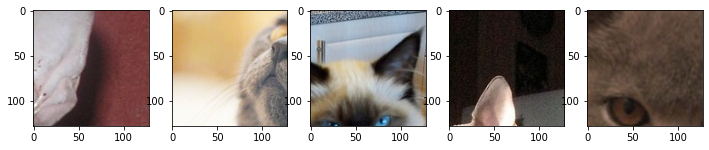

In [ ]:
print('学習に用いる画像')
plt.figure(figsize=(12, 6))
train_paths = glob(osp.join(train_dir, '*'))
for num, path in enumerate(train_paths[0:5], 1):
    image = cv2.imread(path)
    plt.subplot(1, 5, num)
    plt.imshow(image[:,:,::-1])
plt.show()

print('学習の進度確認の画像')
plt.figure(figsize=(12, 4))
test_paths = glob(osp.join(test_dir, '*'))
for num, path in enumerate(test_paths, 1):
    image = cv2.imread(path)
    plt.subplot(1, 5, num)
    plt.imshow(image[:,:,::-1])
plt.show()

print('学習後に超解像を試す画像')
plt.figure(figsize=(12, 4))
demo_paths = glob(osp.join(demo_dir, '*'))
for num, path in enumerate(demo_paths, 1):
    image = cv2.imread(path)
    plt.subplot(1, 5, num)
    plt.imshow(image[:,:,::-1])
plt.show()

# データセット

## import

In [23]:
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.models import vgg19
import torchvision.transforms as transforms

## 定数

In [24]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## 学習用のデータセット読み込みクラス

In [25]:
class ImageDataset(Dataset):
    """
    学習のためのDatasetクラス
    32×32の低解像度の本物画像と、
    128×128の本物画像を出力する
    """
    def __init__(self, dataset_dir, hr_shape):
        hr_height, hr_width = hr_shape
        
        # 低解像度の画像を取得するための処理
        self.lr_transform = transforms.Compose([
            transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])

        # 高像度の画像を取得するための処理
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_height, hr_height), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
        
        self.files = sorted(glob(osp.join(dataset_dir, '*')))
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
        
        return {'lr': img_lr, 'hr': img_hr}
    
    def __len__(self):
        return len(self.files)

## 学習中の画像確認とデモ用のデータセット読み込みクラス

In [26]:
class TestImageDataset(Dataset):
    """
    Generatorによる途中経過の確認のためのDatasetクラス
    lr_transformで入力画像を高さと幅それぞれ1/4の低解像度の画像を生成し、
    hr_transformでオリジナルの画像を高解像度の画像として用いる
    """
    def __init__(self, dataset_dir):
        self.hr_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])
        self.files = sorted(glob(osp.join(dataset_dir, '*')))
    
    def lr_transform(self, img, img_size):
        """
        様々な入力画像のサイズに対応するために、
        入力画像のサイズを1/4にするように処理
        """
        img_width, img_height = img_size
        self.__lr_transform = transforms.Compose([
            transforms.Resize((img_height // 4, 
                               img_width // 4), 
                               Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
        img = self.__lr_transform(img)
        return img
            
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_size = img.size
        img_lr = self.lr_transform(img, img_size)
        img_hr = self.hr_transform(img)        
        return {'lr': img_lr, 'hr': img_hr}
    
    def __len__(self):
        return len(self.files)

# ESRGAN

## 生成器のResidual Block

In [27]:
class DenseResidualBlock(nn.Module):
    """
    GenearatorのDenseResidualBlockのクラス
    """
    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale
        
        def block(in_features, non_linearity=True):
            layers = [nn.Conv2d(in_features, filters, 3, 1, 1, bias=True)]
            if non_linearity:
                layers += [nn.LeakyReLU()]
            return nn.Sequential(*layers)
    
        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]
    
    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x

## 生成器のResidual in Residual Block

In [28]:
class ResidualInResidualDenseBlock(nn.Module):
    """
    GenearatorのResidualInResidualDenseBlockのクラス
    """
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), 
            DenseResidualBlock(filters), 
            DenseResidualBlock(filters)
        )
    
    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

## 生成器

In [29]:
class GeneratorRRDB(nn.Module):
    """
    Generatorのクラス
    """
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2):
        super(GeneratorRRDB, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) 
                                        for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        
        upsample_layers = []
        
        for _ in range(num_upsample):
            upsample_layers += [
                nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(),
                nn.PixelShuffle(upscale_factor=2),
            ]
        self.upsampling = nn.Sequential(*upsample_layers)
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )
    
    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

## 生成器の特徴量抽出器

In [30]:
class FeatureExtractor(nn.Module):
    """
    Perceputual lossを計算するために特徴量を抽出するためのクラス
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(
            vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)

## 識別機

In [31]:
class Discriminator(nn.Module):
    """
    Discriminatorのクラス
    """
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
                
        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)
    
        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, 
                                    out_filters, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, 
                                    out_filters, 
                                    kernel_size=3, 
                                    stride=2, 
                                    padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            print(discriminator_block(in_filters, 
                                      out_filters, 
                                      first_block=(i == 0)))
            layers.extend(discriminator_block(in_filters, 
                                              out_filters, 
                                              first_block=(i == 0)))
            in_filters = out_filters
        
        layers.append(nn.Conv2d(out_filters, 
                                1, 
                                kernel_size=3, 
                                stride=1, 
                                padding=1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, img):
        return self.model(img)

## ESRGAN

In [32]:
class ESRGAN():
    """
    ESRGANの処理を実装するクラス
    """
    def __init__(self, opt):
        self.generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(opt.device)
        self.discriminator = Discriminator(input_shape=(opt.channels, *hr_shape)).to(opt.device)

        self.feature_extractor = FeatureExtractor().to(opt.device)
        self.feature_extractor.eval()

        self.criterion_GAN = nn.BCEWithLogitsLoss().to(opt.device)
        self.criterion_content = nn.L1Loss().to(opt.device)
        self.criterion_pixel = nn.L1Loss().to(opt.device)

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

        self.Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
        self.writer = SummaryWriter(log_dir=log_dir)
    
    def pre_train(self, imgs, batches_done, batch_num):
        """
        loss pixelのみで事前学習を行う
        """
        # preprocess
        imgs_lr = Variable(imgs['lr'].type(self.Tensor))
        imgs_hr = Variable(imgs['hr'].type(self.Tensor))

        # ground truth
        valid = Variable(self.Tensor(np.ones((imgs_lr.size(0), *self.discriminator.output_shape))), 
                          requires_grad=False)
        fake = Variable(self.Tensor(np.zeros((imgs_lr.size(0), *self.discriminator.output_shape))), 
                        requires_grad=False)

        # バックプロパゲーションの前に勾配を0にする
        self.optimizer_G.zero_grad()

        # 低解像度の画像から高解像度の画像を生成
        gen_hr = self.generator(imgs_lr)

        loss_pixel = self.criterion_pixel(gen_hr, imgs_hr)

        # 画素単位の損失であるloss_pixelで事前学習を行う
        loss_pixel.backward()
        self.optimizer_G.step()
        train_info = {'epoch': epoch, 'batch_num': batch_num, 'loss_pixel': loss_pixel.item()}
        if batch_num == 1:
            sys.stdout.write('\n{}'.format(train_info))
        else:
            sys.stdout.write('\r{}'.format('\t'*20))
            sys.stdout.write('\r{}'.format(train_info))
        sys.stdout.flush()

        self.save_loss(train_info, batches_done)

    def train(self, imgs, batches_done, batch_num):
        """
        pixel loss以外の損失も含めて本学習を行う
        """
        # 前処理
        imgs_lr = Variable(imgs['lr'].type(self.Tensor))
        imgs_hr = Variable(imgs['hr'].type(self.Tensor))

        # 正解ラベル
        valid = Variable(self.Tensor(np.ones((imgs_lr.size(0), *self.discriminator.output_shape))), 
                          requires_grad=False)
        fake = Variable(self.Tensor(np.zeros((imgs_lr.size(0), *self.discriminator.output_shape))), 
                        requires_grad=False)

        # 低解像度の画像から高解像度の画像を生成
        self.optimizer_G.zero_grad()
        gen_hr = self.generator(imgs_lr)

        # Pixel loss
        loss_pixel = self.criterion_pixel(gen_hr, imgs_hr)

        # 推論
        pred_real = self.discriminator(imgs_hr).detach()
        pred_fake = self.discriminator(gen_hr)

        # Adversarial loss
        loss_GAN = self.criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Perceptual loss
        gen_feature = self.feature_extractor(gen_hr)
        real_feature = self.feature_extractor(imgs_hr).detach()
        loss_content = self.criterion_content(gen_feature, real_feature)

        # 生成器のloss
        loss_G = loss_content + opt.lambda_adv * loss_GAN + opt.lambda_pixel * loss_pixel
        loss_G.backward()
        self.optimizer_G.step()

        # 識別機のLoss
        self.optimizer_D.zero_grad()
        pred_real = self.discriminator(imgs_hr)
        pred_fake = self.discriminator(gen_hr.detach())

        loss_real = self.criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)            
        loss_fake = self.criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)    
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        self.optimizer_D.step()

        train_info = {'epoch': epoch, 'batch_num': batch_num,  'loss_D': loss_D.item(), 'loss_G': loss_G.item(),
                      'loss_content': loss_content.item(), 'loss_GAN': loss_GAN.item(), 'loss_pixel': loss_pixel.item(),}
        if batch_num == 1:
            sys.stdout.write('\n{}'.format(train_info))
        else:
            sys.stdout.write('\r{}'.format('\t'*20))
            sys.stdout.write('\r{}'.format(train_info))
        sys.stdout.flush()

        self.save_loss(train_info, batches_done)

    def save_loss(self, train_info, batches_done):
        """
        lossの保存
        """
        for k, v in train_info.items():
            self.writer.add_scalar(k, v, batches_done)

    def save_image(self, imgs, batches_done):
        """
        画像の保存
        """
        with torch.no_grad():
            # Save image grid with upsampled inputs and outputs
            imgs_lr = Variable(imgs["lr"].type(self.Tensor))
            gen_hr = self.generator(imgs_lr)
            gen_hr = denormalize(gen_hr)
            self.writer.add_image('image_{}'.format(i), gen_hr[0], batches_done)

            image_batch_save_dir = osp.join(image_test_save_dir, '{:03}'.format(i))
            # gen_hr_dir = osp.join(image_batch_save_dir, "hr_image")
            os.makedirs(image_batch_save_dir, exist_ok=True)
            save_image(gen_hr, osp.join(image_batch_save_dir, "{:09}.png".format(batches_done)), nrow=1, normalize=False)

    def save_weight(self, batches_done):
        """
        重みの保存
        """
        # Save model checkpoints
        generator_weight_path = osp.join(weight_save_dir, "generator_{:08}.pth".format(batches_done))
        discriminator_weight_path = osp.join(weight_save_dir, "discriminator_{:08}.pth".format(batches_done))

        torch.save(self.generator.state_dict(), generator_weight_path)
        torch.save(self.discriminator.state_dict(), discriminator_weight_path)

# 学習

## import

In [33]:
import sys
import json
import random

from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

## シード固定

In [34]:
random.seed(seed)  
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## 関数

In [35]:
def denormalize(tensors):
  """
  高解像度の生成画像の非正規化を行う
  """
  for c in range(3):
    tensors[:, c].mul_(std[c]).add_(mean[c])
  return torch.clamp(tensors, 0, 255)

## パスの定義

In [36]:
# Colab内に保存
output_dir = osp.join(ROOT, 'output')

# Google Driveに保存
# output_dir = osp.join(DRIVE_ROOT, 'output')

In [37]:
image_train_save_dir = osp.join(output_dir, 'image', 'train')
image_test_save_dir = osp.join(output_dir, 'image', 'test')
weight_save_dir = osp.join(output_dir, 'weight')
param_save_path = osp.join(output_dir, 'param.json')

save_dirs = [image_train_save_dir, image_test_save_dir, weight_save_dir]
for save_dir in save_dirs:
    print(save_dir)
    os.makedirs(save_dir, exist_ok=True)

log_dir = './logs'
os.makedirs(log_dir, exist_ok=True)

/content/esrgan/output/image/train
/content/esrgan/output/image/test
/content/esrgan/output/weight


In [38]:
train_data_dir = osp.join(dataset_dir, 'train')
test_data_dir = osp.join(dataset_dir, 'test')
demo_data_dir = osp.join(dataset_dir, 'demo')

## パラメータ

In [39]:
def save_json(file, save_path, mode):
    """Jsonファイルを保存
    """
    with open(save_path, mode) as outfile:
        json.dump(file, outfile, indent=4)

In [40]:

class Opts():
    def __init__(self):
        self.n_epoch = 50
        self.residual_blocks = 23
        self.lr = 0.0002
        self.b1 = 0.9
        self.b2 = 0.999
        self.batch_size = 16
        self.n_cpu = 8
        self.warmup_batches = 500
        self.lambda_adv = 5e-3
        self.lambda_pixel = 1e-2
        self.pretrained = False
        self.dataset_name = 'cat'
        self.sample_interval = 100
        self.checkpoint_interval = 1000
        self.hr_height = 128
        self.hr_width = 128
        self.channels = 3
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def to_dict(self):
        parameters = {
            'n_epoch': self.n_epoch,
            'hr_height': self.hr_height,
            'residual_blocks': self.residual_blocks,
            'lr': self.lr,
            'b1': self.b1,
            'b2': self.b2,
            'batch_size': self.batch_size,
            'n_cpu': self.n_cpu,
            'warmup_batches': self.warmup_batches,
            'lambda_adv': self.lambda_adv,
            'lambda_pixel': self.lambda_pixel,
            'pretrained': self.pretrained,
            'dataset_name': self.dataset_name,
            'sample_interval': self.sample_interval,
            'checkpoint_interval': self.checkpoint_interval,
            'hr_height': self.hr_height,
            'hr_width': self.hr_width,
            'channels': self.channels,
            'device': str(self.device),
        }
        return parameters
opt = Opts()
save_json(opt.to_dict(), param_save_path, 'w')

In [41]:
hr_shape = (opt.hr_height, opt.hr_height)

## データセット

In [42]:
train_dataloader = DataLoader(
    ImageDataset(train_data_dir, hr_shape=hr_shape),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)

test_dataloader = DataLoader(
    TestImageDataset(test_data_dir),
    batch_size=1,
    shuffle=False,
    num_workers=opt.n_cpu,
)

## 学習

In [43]:
# ESRGANを呼び出す
esrgan = ESRGAN(opt)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), LeakyReLU(negative_slope=0.2, inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True)]
[Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True)]
[Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), BatchNorm2d(256, eps=1e-05, momentum=

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [44]:
for epoch in range(1, opt.n_epoch + 1):
    for batch_num, imgs in enumerate(train_dataloader):
        batches_done = (epoch - 1) * len(train_dataloader) + batch_num
        # 事前学習
        if batches_done <= opt.warmup_batches:
            esrgan.pre_train(imgs, batches_done, batch_num)
        # 本学習
        else:
            esrgan.train(imgs, batches_done, batch_num)
        # 高解像度の生成画像の保存
        if batches_done % opt.sample_interval == 0:
            for i, imgs in enumerate(test_dataloader):
                esrgan.save_image(imgs, batches_done)
        # 学習した重みの保存
        if batches_done % opt.checkpoint_interval == 0:
            esrgan.save_weight(batches_done)

{'epoch': 1, 'batch_num': 0, 'loss_pixel': 0.9548396468162537}
{'epoch': 2, 'batch_num': 0, 'loss_D': 0.009052002802491188, 'loss_G': 2.2997491359710693, 'loss_content': 2.268899917602539, 'loss_GAN': 5.432738304138184, 'loss_pixel': 0.36855489015579224}
{'epoch': 3, 'batch_num': 0, 'loss_D': 8.298317698063329e-05, 'loss_G': 1.8946806192398071, 'loss_content': 1.8416471481323242, 'loss_GAN': 10.114603042602539, 'loss_pixel': 0.2460486739873886}
{'epoch': 4, 'batch_num': 0, 'loss_D': 0.0016593709588050842, 'loss_G': 1.7057253122329712, 'loss_content': 1.6663076877593994, 'loss_GAN': 7.497051239013672, 'loss_pixel': 0.19323760271072388}
{'epoch': 5, 'batch_num': 0, 'loss_D': 0.0006417590193450451, 'loss_G': 1.7014567852020264, 'loss_content': 1.647025227546692, 'loss_GAN': 10.410135269165039, 'loss_pixel': 0.2380799949169159}
{'epoch': 6, 'batch_num': 0, 'loss_D': 0.0024687862023711205, 'loss_G': 1.56819486618042, 'loss_content': 1.5268218517303467, 'loss_GAN': 7.843581199645996, 'loss_p

# 超解像を試してみよう

## パスの定義

In [45]:
# 学習後に超解像を試す画像の超解像の結果を保存するディレクトリ
demo_out_dir = osp.join(output_dir, dataset_name)
os.makedirs(demo_out_dir, exist_ok=True)

## 学習した重みを用いて超解像

In [46]:
# 学習した生成器の重みから最新の重みを取得する
generator_weight_paths = [p for p in glob(osp.join(weight_save_dir, 'gen*'))]
generator_weight_paths.sort()
generator_weight_path = generator_weight_paths[-1]

In [47]:
# 生成器を呼び出して重みをロードする
generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(opt.device)
generator.load_state_dict(torch.load(generator_weight_path))

<All keys matched successfully>

In [48]:
# デモのためのデータローダーを呼び出す
demo_dataloader = DataLoader(
    TestImageDataset(demo_data_dir),
    batch_size=1,
    shuffle=False,
    num_workers=opt.n_cpu,
)

In [49]:
Tensor = torch.cuda.FloatTensor \
    if torch.cuda.is_available() else torch.Tensor
with torch.no_grad():
    for i, imgs in enumerate(demo_dataloader):
        imgs_lr = Variable(imgs["lr"].type(Tensor))

        # 生成器による超解像画像の生成
        gen_hr = generator(imgs_lr)
        # 低解像度の画像のリサイズ（比較用）
        imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)

        # 画像の非正規化
        imgs_lr = denormalize(imgs_lr)
        gen_hr = denormalize(gen_hr)

        # 画像の保存
        os.makedirs(demo_out_dir, exist_ok=True)
        save_image(imgs_lr, osp.join(demo_out_dir, 
                                      "low_{:01}.png".format(i)), 
                    nrow=1, normalize=False)
        save_image(gen_hr, osp.join(demo_out_dir, 
                                    "gen_hr_{:01}.png".format(i)), 
                    nrow=1, normalize=False)

## 超解像結果の表示

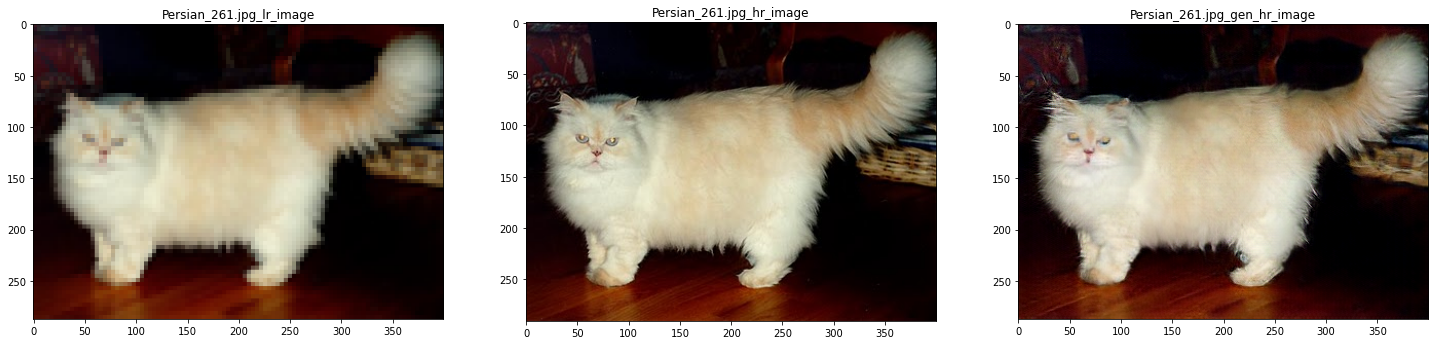

In [50]:
# 低解像度の入力画像のパス
lr_img_paths = glob(osp.join(demo_out_dir, 'low*'))
lr_img_paths.sort()
# 高解像度の本物画像のパス
hr_img_paths = glob(osp.join(demo_data_dir, '*'))
hr_img_paths.sort()
# 高解像度の生成画像のパス
gen_hr_img_paths = glob(osp.join(demo_out_dir, 'gen_hr*'))
gen_hr_img_paths.sort()

plt.figure(figsize=(25, 20))
for lr_img_path, hr_img_path, gen_hr_img_path in zip(lr_img_paths, 
                                                     hr_img_paths, 
                                                     gen_hr_img_paths):
    image_name = osp.basename(hr_img_path)
    lr_image = cv2.imread(lr_img_path)
    hr_image = cv2.imread(hr_img_path)
    gen_hr_image = cv2.imread(gen_hr_img_path)

    # 低解像度の入力画像
    plt.subplot(1,3,1)
    plt.imshow(lr_image[:,:,::-1])
    plt.title('{}_{}'.format(image_name, 'lr_image'))

    # 高解像度の本物画像
    plt.subplot(1,3,2)
    plt.imshow(hr_image[:,:,::-1])
    plt.title('{}_{}'.format(image_name, 'hr_image'))

    # 高解像度の生成画像
    plt.subplot(1,3,3)
    plt.imshow(gen_hr_image[:,:,::-1])
    plt.title('{}_{}'.format(image_name, 'gen_hr_image'))

    plt.show()